# 1 查看python和pip版本

In [1]:
!python --version
!pip --version

# !python -m pip install --upgrade pip

Python 3.10.6
pip 24.3.1 from C:\Users\kangt\.pyenv-win-venv\envs\my-jupyter\lib\site-packages\pip (python 3.10)



## 验证是否使用了虚拟环境，查看输出是否为你的虚拟环境的 Python 路径

In [2]:
import sys
print(sys.executable)

C:\Users\kangt\.pyenv-win-venv\envs\my-jupyter\Scripts\python.exe


# 2 安装vanna、向量数据库、openai

向量存储使用chromadb，模型使用openai的模型
vanna 是主包名称，[chromadb,openai] 是 vanna 的可选依赖项（extras），表示同时安装 vanna 包以及它所需的 chromadb 和 openai 依赖。
-q 是 --quiet 的简写，表示静默模式，减少安装过程中的输出信息。
-U 是 --upgrade 的简写，表示升级已安装的包到最新版本。

In [4]:
print('开始安装依赖')

!pip install "vanna[chromadb,openai]" pandas -U

print('安装完成')

开始安装依赖
安装完成


# 3 导入pandas和sqlite3

In [5]:
import pandas as pd
import sqlite3

# 4 导入csv文件到sqllite数据库

In [6]:
def import_csv_to_sqlite(csv_path, db_name='nba_shots.db'):
  df = pd.read_csv(csv_path, on_bad_lines='skip')
  conn = sqlite3.connect(db_name)
  df.to_sql('nba_shots', conn, if_exists='replace', index=False)
  conn.close()

  print(f"CSV file '{csv_path}' has been imported to SQLite database '{db_name}'.")

In [ ]:
import_csv_to_sqlite('NBA_2024_Shots.csv')

# 5 初始化

 - openai客户端
 - 向量数据库

In [7]:
from vanna.openai import OpenAI_Chat
from vanna.chromadb import ChromaDB_VectorStore
from openai import OpenAI

In [10]:
OPENAI_API_KEY = ''
OPENAI_BASE_URL = 'https://api.deepseek.com/v1'

# 初始化客户端
client = OpenAI(
  api_key=OPENAI_API_KEY,
  base_url=OPENAI_BASE_URL
)

In [11]:
class MyVanna(OpenAI_Chat, ChromaDB_VectorStore):
  def __init__(self, client, config=None, ):
    ChromaDB_VectorStore.__init__(self, config=config)
    OpenAI_Chat.__init__(self, client, config=config)

vn = MyVanna(client, config={ 'model': 'deepseek-chat' })

# 6 连接数据库，将数据库的描述信息写入向量数据库（训练）

In [12]:
vn.connect_to_sqlite("../data/nba_shots.db")

In [13]:
documentation = '''
#表名称：nba_shots
该表记录了NBA比赛中球员的投篮数据，包括投篮位置、投篮类型、投篮结果以及比赛时间等信息，适用于篮球数据分析和研究。
#以下是表 nba_shots 中各列的含义说明：
SEASON_1 & SEASON_2: 赛季指示变量，用于区分不同赛季。
TEAM_ID: NBA API 中特定球队的唯一标识符。
TEAM_NAME: NBA API 中特定球队的名称。
PLAYER_ID: NBA API 中特定球员的唯一标识符。
PLAYER_NAME: NBA API 中特定球员的名称。
GAME_DATE: 比赛日期（格式为月-日-年，即 M-D-Y）。
GAME_ID: NBA API 中特定比赛的唯一标识符。
EVENT_TYPE: 表示投篮结果的字符变量（命中投篮 // 未命中投篮）。
SHOT_MADE: 表示投篮结果的布尔变量（True 表示命中，False 表示未命中）。
ACTION_TYPE: 投篮类型的描述（例如上篮、扣篮、跳投等）。
SHOT_TYPE: 投篮类型（2分球或3分球）。
BASIC_ZONE: 投篮发生的球场区域名称。包括：禁区（Restricted Area）、油漆区非禁区（In the Paint (non-RA)）、中距离（Midrange）、左侧底角三分（Left Corner 3）、右侧底角三分（Right Corner 3）、弧顶三分（Above the Break）、后场（Backcourt）。
ZONE_NAME: 投篮发生的球场侧边区域名称。包括：左侧（left）、左侧中心（left side center）、中心（center）、右侧中心（right side center）、右侧（right）。
ZONE_ABB: 球场侧边区域的缩写。包括：(L) 左侧，(LC) 左侧中心，(C) 中心，(RC) 右侧中心，(R) 右侧。
ZONE_RANGE: 投篮距离的区域范围。包括：小于8英尺（Less than 8 ft.）、8-16英尺（8-16 ft.）、16-24英尺（16-24 ft.）、24英尺以上（24+ ft.）。
LOC_X: 投篮在球场平面坐标系中的X坐标（范围为0到50）。
LOC_Y: 投篮在球场平面坐标系中的Y坐标（范围为0到50）。
SHOT_DISTANCE: 投篮距离篮筐中心的距离，单位为英尺。
QUARTER: 比赛的第几节。
MINS_LEFT: 当前节剩余的分钟数。
SECS_LEFT: 当前分钟剩余的秒数。
'''

In [14]:
vn.train(documentation=f"请参考以下内容以了解“源数据”中各列的含义。{documentation}")

Adding documentation....


C:\Users\kangt\.cache\chroma\onnx_models\all-MiniLM-L6-v2\onnx.tar.gz: 100%|████████████████████████████████████████████| 79.3M/79.3M [00:40<00:00, 2.05MiB/s]


'7a32303e-3a30-5980-b5dc-ed058303c5ba-doc'

# 7 开始使用自然语言进行查询

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


SQL Prompt: [{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Additional Context \n\n请参考以下内容以了解“源数据”中各列的含义。\n#表名称：nba_shots\n该表记录了NBA比赛中球员的投篮数据，包括投篮位置、投篮类型、投篮结果以及比赛时间等信息，适用于篮球数据分析和研究。\n#以下是表 nba_shots 中各列的含义说明：\nSEASON_1 & SEASON_2: 赛季指示变量，用于区分不同赛季。\nTEAM_ID: NBA API 中特定球队的唯一标识符。\nTEAM_NAME: NBA API 中特定球队的名称。\nPLAYER_ID: NBA API 中特定球员的唯一标识符。\nPLAYER_NAME: NBA API 中特定球员的名称。\nGAME_DATE: 比赛日期（格式为月-日-年，即 M-D-Y）。\nGAME_ID: NBA API 中特定比赛的唯一标识符。\nEVENT_TYPE: 表示投篮结果的字符变量（命中投篮 // 未命中投篮）。\nSHOT_MADE: 表示投篮结果的布尔变量（True 表示命中，False 表示未命中）。\nACTION_TYPE: 投篮类型的描述（例如上篮、扣篮、跳投等）。\nSHOT_TYPE: 投篮类型（2分球或3分球）。\nBASIC_ZONE: 投篮发生的球场区域名称。包括：禁区（Restricted Area）、油漆区非禁区（In the Paint (non-RA)）、中距离（Midrange）、左侧底角三分（Left Corner 3）、右侧底角三分（Right Corner 3）、弧顶三分（Above the Break）、后场（Backcourt）。\nZONE_NAME: 投篮发生的球场侧边区域名称。包括：左侧（left）、左侧中心（

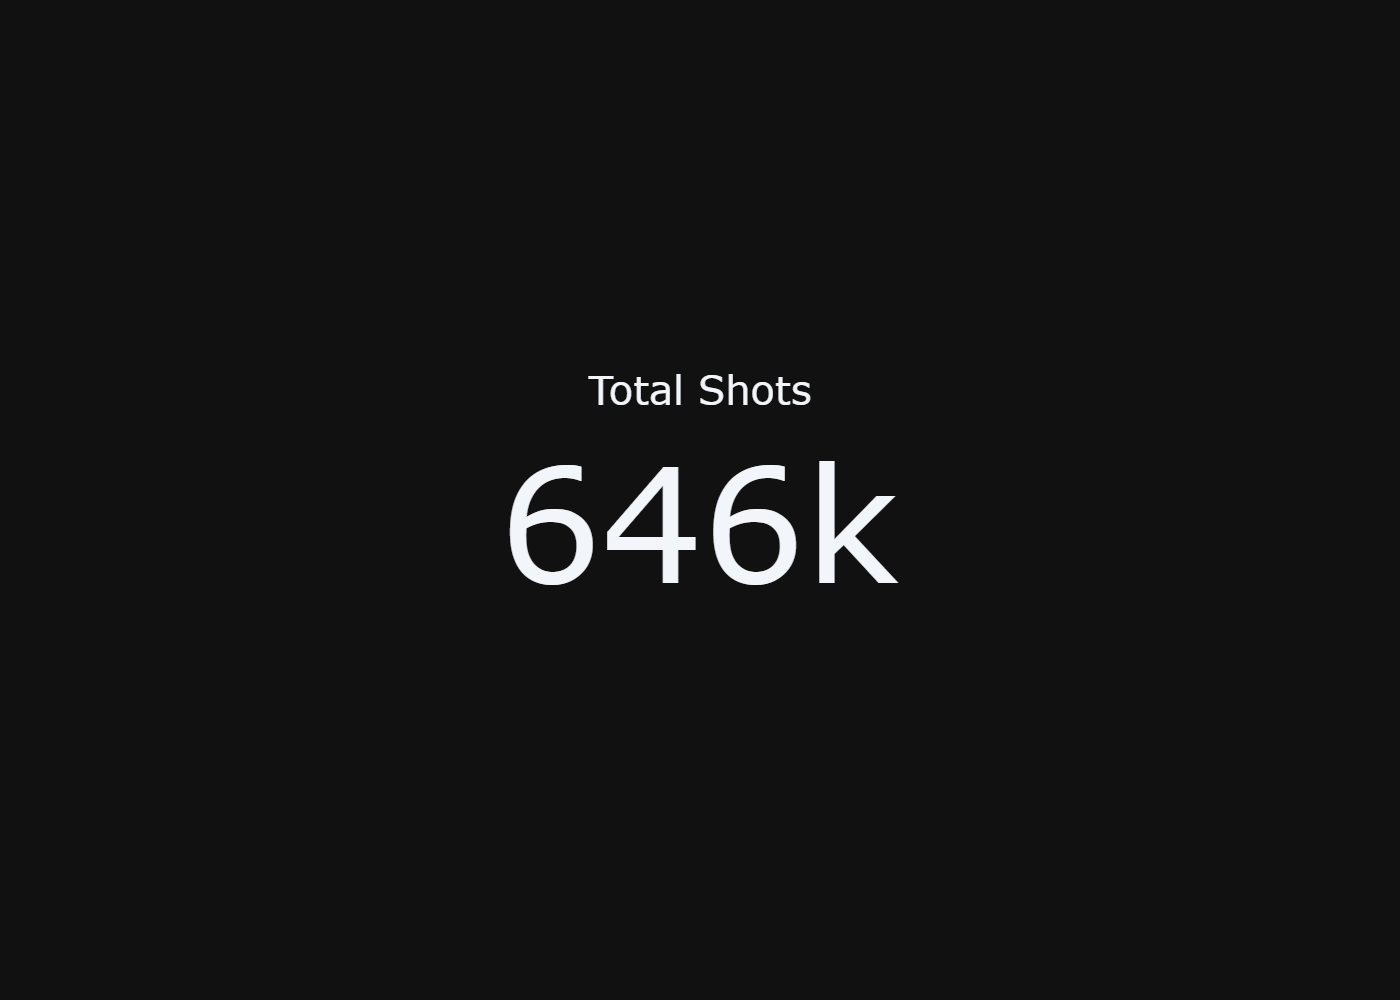

In [15]:
response = vn.ask("总共有多少次投篮？")

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


SQL Prompt: [{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Additional Context \n\n请参考以下内容以了解“源数据”中各列的含义。\n#表名称：nba_shots\n该表记录了NBA比赛中球员的投篮数据，包括投篮位置、投篮类型、投篮结果以及比赛时间等信息，适用于篮球数据分析和研究。\n#以下是表 nba_shots 中各列的含义说明：\nSEASON_1 & SEASON_2: 赛季指示变量，用于区分不同赛季。\nTEAM_ID: NBA API 中特定球队的唯一标识符。\nTEAM_NAME: NBA API 中特定球队的名称。\nPLAYER_ID: NBA API 中特定球员的唯一标识符。\nPLAYER_NAME: NBA API 中特定球员的名称。\nGAME_DATE: 比赛日期（格式为月-日-年，即 M-D-Y）。\nGAME_ID: NBA API 中特定比赛的唯一标识符。\nEVENT_TYPE: 表示投篮结果的字符变量（命中投篮 // 未命中投篮）。\nSHOT_MADE: 表示投篮结果的布尔变量（True 表示命中，False 表示未命中）。\nACTION_TYPE: 投篮类型的描述（例如上篮、扣篮、跳投等）。\nSHOT_TYPE: 投篮类型（2分球或3分球）。\nBASIC_ZONE: 投篮发生的球场区域名称。包括：禁区（Restricted Area）、油漆区非禁区（In the Paint (non-RA)）、中距离（Midrange）、左侧底角三分（Left Corner 3）、右侧底角三分（Right Corner 3）、弧顶三分（Above the Break）、后场（Backcourt）。\nZONE_NAME: 投篮发生的球场侧边区域名称。包括：左侧（left）、左侧中心（

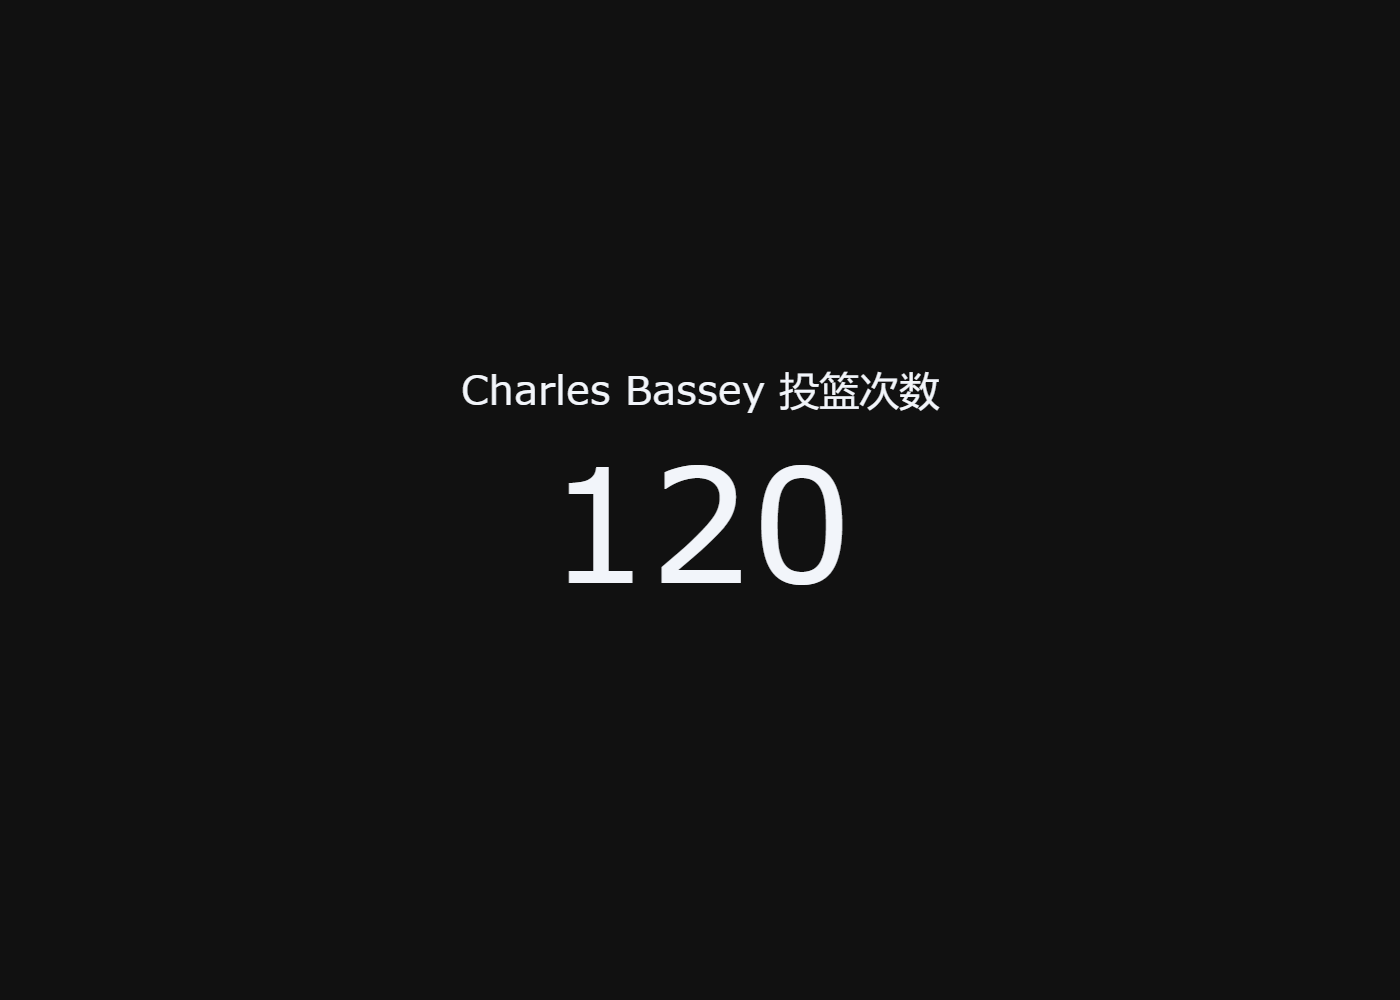

("SELECT COUNT(*) AS total_shots \nFROM nba_shots \nWHERE PLAYER_NAME = 'Charles Bassey';",
    total_shots
 0          120,
 Figure({
     'data': [{'mode': 'number', 'title': {'text': 'Charles Bassey 投篮次数'}, 'type': 'indicator', 'value': np.int64(120)}],
     'layout': {'template': '...'}
 }))

In [19]:
vn.ask("Charles Bassey投篮次数是多少？")

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


SQL Prompt: [{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Additional Context \n\n请参考以下内容以了解“源数据”中各列的含义。\n#表名称：nba_shots\n该表记录了NBA比赛中球员的投篮数据，包括投篮位置、投篮类型、投篮结果以及比赛时间等信息，适用于篮球数据分析和研究。\n#以下是表 nba_shots 中各列的含义说明：\nSEASON_1 & SEASON_2: 赛季指示变量，用于区分不同赛季。\nTEAM_ID: NBA API 中特定球队的唯一标识符。\nTEAM_NAME: NBA API 中特定球队的名称。\nPLAYER_ID: NBA API 中特定球员的唯一标识符。\nPLAYER_NAME: NBA API 中特定球员的名称。\nGAME_DATE: 比赛日期（格式为月-日-年，即 M-D-Y）。\nGAME_ID: NBA API 中特定比赛的唯一标识符。\nEVENT_TYPE: 表示投篮结果的字符变量（命中投篮 // 未命中投篮）。\nSHOT_MADE: 表示投篮结果的布尔变量（True 表示命中，False 表示未命中）。\nACTION_TYPE: 投篮类型的描述（例如上篮、扣篮、跳投等）。\nSHOT_TYPE: 投篮类型（2分球或3分球）。\nBASIC_ZONE: 投篮发生的球场区域名称。包括：禁区（Restricted Area）、油漆区非禁区（In the Paint (non-RA)）、中距离（Midrange）、左侧底角三分（Left Corner 3）、右侧底角三分（Right Corner 3）、弧顶三分（Above the Break）、后场（Backcourt）。\nZONE_NAME: 投篮发生的球场侧边区域名称。包括：左侧（left）、左侧中心（

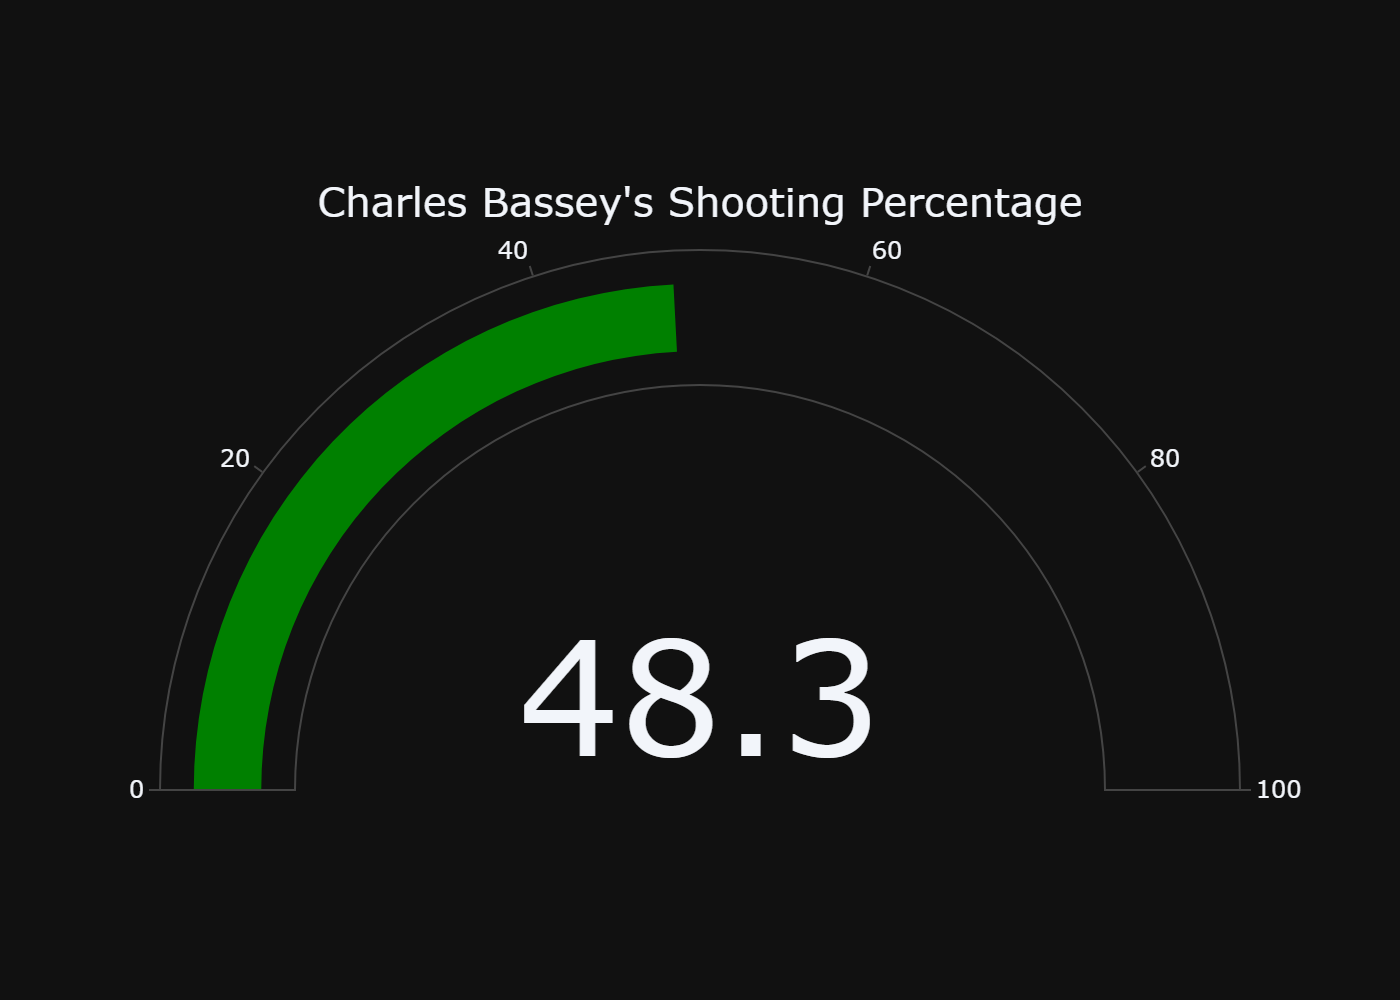

("SELECT \n    ROUND(SUM(CASE WHEN SHOT_MADE = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS shooting_percentage\nFROM \n    nba_shots\nWHERE \n    PLAYER_NAME = 'Charles Bassey';",
    shooting_percentage
 0                48.33,
 Figure({
     'data': [{'gauge': {'axis': {'range': [None, 100]}},
               'mode': 'gauge+number',
               'title': {'text': "Charles Bassey's Shooting Percentage"},
               'type': 'indicator',
               'value': np.float64(48.33)}],
     'layout': {'template': '...'}
 }))

In [17]:
vn.ask("Charles Bassey的投篮命中率是百分之多少？")

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


SQL Prompt: [{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Additional Context \n\n请参考以下内容以了解“源数据”中各列的含义。\n#表名称：nba_shots\n该表记录了NBA比赛中球员的投篮数据，包括投篮位置、投篮类型、投篮结果以及比赛时间等信息，适用于篮球数据分析和研究。\n#以下是表 nba_shots 中各列的含义说明：\nSEASON_1 & SEASON_2: 赛季指示变量，用于区分不同赛季。\nTEAM_ID: NBA API 中特定球队的唯一标识符。\nTEAM_NAME: NBA API 中特定球队的名称。\nPLAYER_ID: NBA API 中特定球员的唯一标识符。\nPLAYER_NAME: NBA API 中特定球员的名称。\nGAME_DATE: 比赛日期（格式为月-日-年，即 M-D-Y）。\nGAME_ID: NBA API 中特定比赛的唯一标识符。\nEVENT_TYPE: 表示投篮结果的字符变量（命中投篮 // 未命中投篮）。\nSHOT_MADE: 表示投篮结果的布尔变量（True 表示命中，False 表示未命中）。\nACTION_TYPE: 投篮类型的描述（例如上篮、扣篮、跳投等）。\nSHOT_TYPE: 投篮类型（2分球或3分球）。\nBASIC_ZONE: 投篮发生的球场区域名称。包括：禁区（Restricted Area）、油漆区非禁区（In the Paint (non-RA)）、中距离（Midrange）、左侧底角三分（Left Corner 3）、右侧底角三分（Right Corner 3）、弧顶三分（Above the Break）、后场（Backcourt）。\nZONE_NAME: 投篮发生的球场侧边区域名称。包括：左侧（left）、左侧中心（

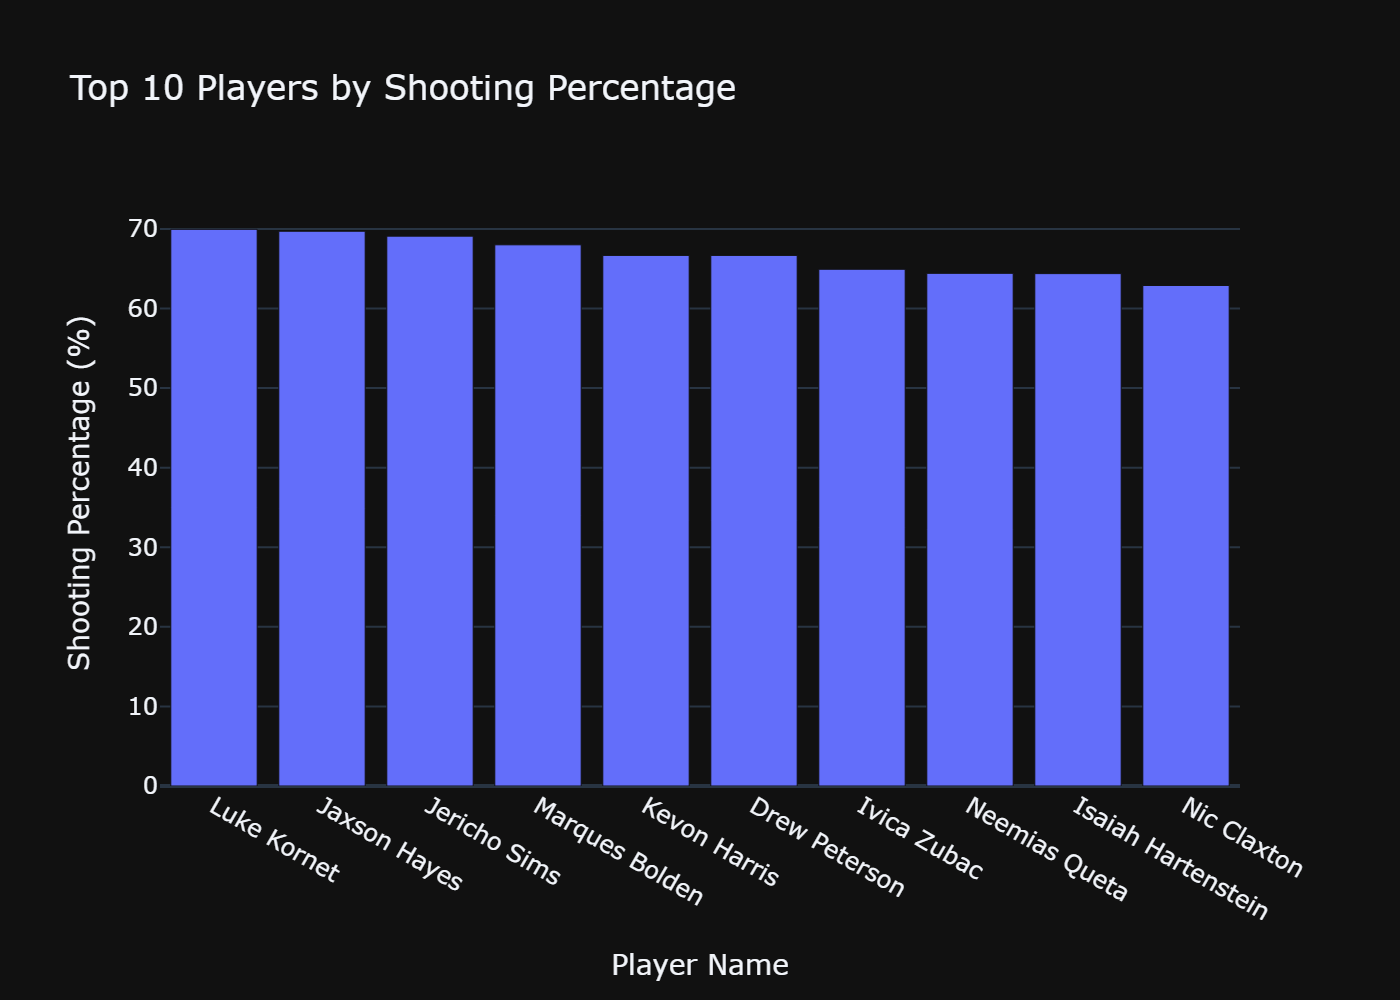

('SELECT \n    PLAYER_NAME, \n    ROUND(SUM(CASE WHEN SHOT_MADE = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS shooting_percentage\nFROM \n    nba_shots\nGROUP BY \n    PLAYER_NAME\nHAVING \n    COUNT(*) > 0\nORDER BY \n    shooting_percentage DESC\nLIMIT 10;',
           PLAYER_NAME  shooting_percentage
 0         Luke Kornet                69.95
 1        Jaxson Hayes                69.71
 2        Jericho Sims                69.09
 3      Marques Bolden                68.00
 4        Kevon Harris                66.67
 5       Drew Peterson                66.67
 6         Ivica Zubac                64.93
 7       Neemias Queta                64.42
 8  Isaiah Hartenstein                64.38
 9         Nic Claxton                62.89,
 Figure({
     'data': [{'alignmentgroup': 'True',
               'hovertemplate': 'Player Name=%{x}<br>Shooting Percentage (%)=%{y}<extra></extra>',
               'legendgroup': '',
               'marker': {'color': '#636efa', 'pattern': {'shape': 

In [18]:
vn.ask("查询命中率最高的10位球员，并返回命中率？")